In [1]:
import os 
os.chdir(r'C:\Users\braya\Documents\github\colibri-hdsp')

Demo CASSI Reconstruction

In [2]:
#General imports
import matplotlib.pyplot as plt
import torch
import os


# Check GPU support
print("GPU support: ", torch.cuda.is_available())

GPU support:  True


Load Dataset

In [3]:
from colibri_hdsp.data.datasets import Dataset

# Load dataset

dataset_path = 'cifar10'
keys = ''
batch_size = 32

dataset = Dataset(dataset_path, keys, batch_size)

Loading dataset:  cifar10
Files already downloaded and verified
Files already downloaded and verified


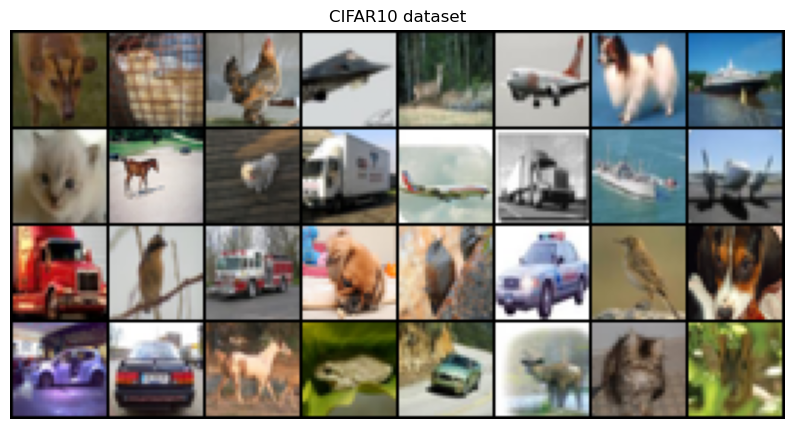

In [4]:
# import make_grid from torchvision
from torchvision.utils import make_grid

sample = next(iter(dataset.train_dataset))[0]

img = make_grid(sample, nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()

Optics Layer

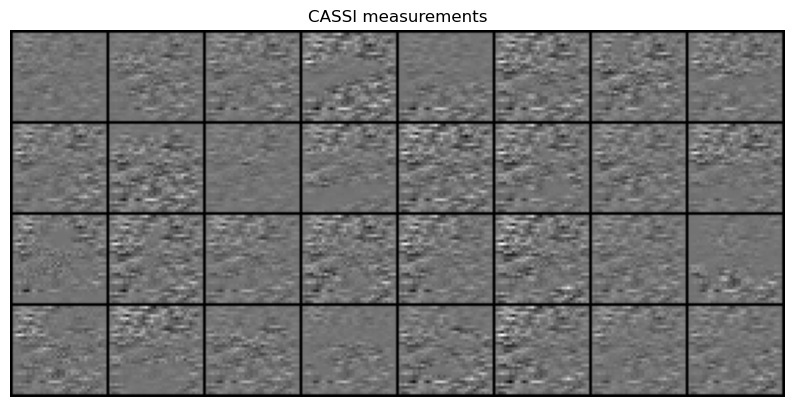

In [5]:
from colibri_hdsp.optics.cassi import CASSI

mode = 'base' # Type of CASSi optical system
cassi =  CASSI(sample.shape[1:], mode, "cpu", trainable=True) # CASSI layer
y = cassi(sample) # CASSI measurements

img = make_grid(y, nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)


plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title('CASSI measurements')
plt.show()

Build Model

In [6]:
import torch.nn as nn
from colibri_hdsp.models import build_network, Unet


class CASSIRecons(nn.Module):
    def __init__(self, cassi):
        super().__init__()
        self.cassi = cassi
        self.model = build_network(Unet, in_channels=cassi.L, out_channels=cassi.L)
        
    def forward(self, x):
        y = self.cassi(x)
        x_init = self.cassi(y, type_calculation="backward")
        x_hat = self.model(x_init)
        return x_hat



model = CASSIRecons(cassi)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

Training Loop

In [7]:
from colibri_hdsp.metrics import psnr, ssim
epochs = 100

for epoch in range(epochs):

    for batch_idx, (x, _) in enumerate(dataset.train_dataset):
        optimizer.zero_grad()

        x_est   = model(x)

        loss = criterion(x, x_est)
        loss.backward()
        optimizer.step()

        psnr_val = psnr(x, x_est)
        ssim_val = ssim(x, x_est)
        
        print('Epoch: {} | Batch: {}/{} | Loss: {:.6f} | PSNR: {:.4f} | SSIM: {:.4f}'.format(
            epoch + 1, batch_idx + 1, len(dataset.train_dataset), loss.item(), psnr_val.item(), ssim_val.item()))


Epoch: 1 | Batch: 1/1563 | Loss: 0.065973 | PSNR: 11.8063 | SSIM: 0.0839
Epoch: 1 | Batch: 2/1563 | Loss: 0.066694 | PSNR: 11.7591 | SSIM: 0.0937
Epoch: 1 | Batch: 3/1563 | Loss: 0.063414 | PSNR: 11.9781 | SSIM: 0.0841
Epoch: 1 | Batch: 4/1563 | Loss: 0.067876 | PSNR: 11.6828 | SSIM: 0.0807
Epoch: 1 | Batch: 5/1563 | Loss: 0.073074 | PSNR: 11.3624 | SSIM: 0.0832
Epoch: 1 | Batch: 6/1563 | Loss: 0.072838 | PSNR: 11.3764 | SSIM: 0.0900
Epoch: 1 | Batch: 7/1563 | Loss: 0.061010 | PSNR: 12.1460 | SSIM: 0.0895
Epoch: 1 | Batch: 8/1563 | Loss: 0.061168 | PSNR: 12.1348 | SSIM: 0.0913
Epoch: 1 | Batch: 9/1563 | Loss: 0.068467 | PSNR: 11.6452 | SSIM: 0.0905
Epoch: 1 | Batch: 10/1563 | Loss: 0.049783 | PSNR: 13.0292 | SSIM: 0.0945
Epoch: 1 | Batch: 11/1563 | Loss: 0.059869 | PSNR: 12.2280 | SSIM: 0.1005
Epoch: 1 | Batch: 12/1563 | Loss: 0.059802 | PSNR: 12.2328 | SSIM: 0.0986
Epoch: 1 | Batch: 13/1563 | Loss: 0.057995 | PSNR: 12.3661 | SSIM: 0.1017
Epoch: 1 | Batch: 14/1563 | Loss: 0.053791 | PS

KeyboardInterrupt: 